In [ ]:
# import sys
# !{sys.executable} -m pip install numpy pandas matplotlib sklearn seaborn

In [1]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

import os
import gensim
import pickle
import zipfile
from urllib import request

import numpy as np
import pandas as pd

import seaborn as sns
from mpl_toolkits import mplot3d

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.python.client import device_lib

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, Lambda, Add, Concatenate, Multiply, Subtract, Flatten, Dropout

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from gensim.models.doc2vec import Doc2Vec

# Resets notebook state
tf.keras.backend.clear_session()

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
%matplotlib inline

In [2]:
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(get_available_devices())

Num GPUs Available:  0
['/device:CPU:0', '/device:XLA_CPU:0']


In [3]:
def download(url, filename, local=True):
    """Download a file if not present"""
    if not local and not os.path.exists(filename):
        print("downloading {}...".format(filename))
        filename, _ = request.urlretrieve(url + filename, filename)

        print("extracting {}...".format(filename))
        with zipfile.ZipFile(filename) as f:
            f.extractall()
            print("extracting {} done".format(filename))

    """directory data"""
    data_path = filename.replace('.zip','')
    if not os.path.exists(data_path):
        if os.path.exists(filename):
            print("extracting {}...".format(filename))
            with zipfile.ZipFile(filename) as f:
                f.extractall()
                print("extracting {} done".format(filename))
        else:
            print('data.zip not found!')

    """directory model for saving model while training"""
    if not os.path.exists('model'):
        os.mkdir('model')
        print("directory model created...")

    return data_path

In [4]:
# download dataset
download(url='https://github.com/kadriansyah/notebook/raw/master/alodokter-recommender/', filename="data.zip", local=True)

'data'

#### Loading in data

In [5]:
n_tag = 5040
tag_max_len = 5

def load_posts():
    df = pd.read_csv('data/articles_20200304.csv', sep=',', header=0, encoding="latin-1")
    df.columns = ['idx','post_id', 'title', 'tags']
    return df[['post_id', 'title', 'tags']]

def load_posts_ctr():
    df = pd.read_csv('data/articles_doc2vec_20200304.csv', sep=',', header=0, encoding="latin-1")
    df.columns = ['post_id', 'related_post_id', 'ctr']
    return df

def text2seq(text, n_tag):
    """ using tokenizer to encoded the multi-level categorical feature """
    tokenizer = Tokenizer(lower=True, split='|',filters='', num_words=n_tag)
    tokenizer.fit_on_texts(text)
    seq = tokenizer.texts_to_sequences(text)
    seq = pad_sequences(seq, maxlen=tag_max_len,padding='post')
    return seq

#### KMeans

In [6]:
print('load kmeans model...')
kmeans_model = pickle.load(open('model/kmeans.pkl', 'rb'))
clusters = kmeans_model.labels_.tolist()
print('load kmeans model done')

load kmeans model...
load kmeans model done


##### Doc3Vec

In [7]:
print('loading doc2vec model...')
doc2vec_model = Doc2Vec.load('model/alodokter-articles-doc2vec.model')
print('loading doc2vec model done')

loading doc2vec model...
loading doc2vec model done


In [8]:
print('loading pid_post_id...')
pid_post_id = pickle.load(open('model/pid_post_id.pkl', 'rb'))
print('loading pid_post_id...')

post_id_pid = {}
for pid, post_id in pid_post_id.items():
    post_id_pid[post_id] = pid

loading pid_post_id...
loading pid_post_id...


In [9]:
# create dictionary doc-id to cluster-id
clusters_docs = {}
docs_clusters = {(idx, cluster) for idx, cluster in enumerate(clusters)}
for item in docs_clusters:
    if item[1] in clusters_docs.keys():
        clusters_docs[item[1]].append(item[0])
    else:
        clusters_docs[item[1]] = [item[0]]

In [10]:
all_posts = load_posts()
all_posts

,post_id,title,tags
0,511096,Peran dan Dampak Karbon Dioksida terhadap Tubu...,hasil lab|metabolisme
1,84485,Oksigenasi Bisa Membantu Menyembuhkan Penyakit...,asma|HIPOKSIA|ppok|sesak napas|sleep apnea
2,834460,Seperti Ini Cara Kerja Sistem Pernapasan pada ...,infeksi saluran pernapasan|sesak napas|sinusitis
3,779117,Waspadai Penyakit Penyebab Gangguan Pernapasan...,alergi|asma|sesak napas
4,631994,Penyebab Gusi Bengkak Bernanah dan Pencegahannya,radang gusi
...,...,...,...
5807,476063,Persiapan Khusus bagi Pengidap Diabetes sebelu...,demam|diabetes tipe 1|diabetes tipe 2|diabetes...
5808,439056,Atur Keuanganmu dengan Baik Agar Terhindar dar...,bunuh diri|depresi|kesehatan mental|psikologi
5809,500630,"Hidrasi Tepat, Cepat Pulihkan Flu",anak|batuk|bayi|Dehidrasi|demam|flu|orang tua|...
5810,37676,Ayo Konsumsi Makanan Berlemak Agar Tubuh Lebih...,obesitas


In [11]:
all_posts['tags'] = text2seq(all_posts.tags.values, n_tag=n_tag).tolist()
all_posts

,post_id,title,tags
0,511096,Peran dan Dampak Karbon Dioksida terhadap Tubu...,"[96, 72, 0, 0, 0]"
1,84485,Oksigenasi Bisa Membantu Menyembuhkan Penyakit...,"[57, 254, 175, 43, 190]"
2,834460,Seperti Ini Cara Kerja Sistem Pernapasan pada ...,"[80, 43, 97, 0, 0]"
3,779117,Waspadai Penyakit Penyebab Gangguan Pernapasan...,"[24, 57, 43, 0, 0]"
4,631994,Penyebab Gusi Bengkak Bernanah dan Pencegahannya,"[91, 0, 0, 0, 0]"
...,...,...,...
5807,476063,Persiapan Khusus bagi Pengidap Diabetes sebelu...,"[116, 36, 10, 79, 112]"
5808,439056,Atur Keuanganmu dengan Baik Agar Terhindar dar...,"[454, 41, 16, 8, 0]"
5809,500630,"Hidrasi Tepat, Cepat Pulihkan Flu","[52, 90, 54, 65, 73]"
5810,37676,Ayo Konsumsi Makanan Berlemak Agar Tubuh Lebih...,"[19, 0, 0, 0, 0]"


In [12]:
# lookup dictionary
post_id_title = {}
for index, row in all_posts.iterrows():
    post_id_title[row.post_id] = row.title
len(post_id_title)

5812

In [13]:
# lookup dictionary
post_id_tags = {}
for index, row in all_posts.iterrows():
    post_id_tags[row.post_id] = row.tags
len(post_id_tags)

5812

In [14]:
pids = clusters_docs[0]
post_ids = [pid_post_id[pid] for pid in pids]
len(post_ids)

544

In [15]:
# posts = all_posts[all_posts['post_id'].isin(post_ids)]
# posts
posts = all_posts
posts

,post_id,title,tags
0,511096,Peran dan Dampak Karbon Dioksida terhadap Tubu...,"[96, 72, 0, 0, 0]"
1,84485,Oksigenasi Bisa Membantu Menyembuhkan Penyakit...,"[57, 254, 175, 43, 190]"
2,834460,Seperti Ini Cara Kerja Sistem Pernapasan pada ...,"[80, 43, 97, 0, 0]"
3,779117,Waspadai Penyakit Penyebab Gangguan Pernapasan...,"[24, 57, 43, 0, 0]"
4,631994,Penyebab Gusi Bengkak Bernanah dan Pencegahannya,"[91, 0, 0, 0, 0]"
...,...,...,...
5807,476063,Persiapan Khusus bagi Pengidap Diabetes sebelu...,"[116, 36, 10, 79, 112]"
5808,439056,Atur Keuanganmu dengan Baik Agar Terhindar dar...,"[454, 41, 16, 8, 0]"
5809,500630,"Hidrasi Tepat, Cepat Pulihkan Flu","[52, 90, 54, 65, 73]"
5810,37676,Ayo Konsumsi Makanan Berlemak Agar Tubuh Lebih...,"[19, 0, 0, 0, 0]"


In [16]:
posts.sample(20)

,post_id,title,tags
3953,189066,Mencoba Khasiat Obat Herbal Asam Lambung,"[51, 10, 0, 0, 0]"
5456,923004,Kenali Gejala Atresia Bilier dan Cara Mengatas...,"[3, 657, 7, 0, 0]"
3942,183925,Mengenal Habitat dan Kebiasaan Nyamuk Demam Be...,"[66, 473, 0, 0, 0]"
2537,1623764,Bisakah Karang Gigi Dibersihkan Sendiri di Rumah?,"[620, 734, 0, 0, 0]"
2681,512405,Ketahui Manfaat Kedelai Hitam untuk Kesehatan,"[1, 0, 0, 0, 0]"
2513,1628504,Gejala dan Pengobatan Scabies pada Anak,"[4, 476, 0, 0, 0]"
4282,109088,Berbagai Cara Membesarkan Bokong,"[6, 11, 1081, 0, 0]"
5513,949237,"Hati-hati, Kelebihan Vitamin A Dapat Memicu Ke...","[1, 25, 136, 0, 0]"
1594,397106,5 Tanda Kamu Mungkin Terkena Kanker Rahim,"[275, 0, 0, 0, 0]"
1002,1716301,Ketahui Lebih Jauh Seputar Sindrom Kelelahan K...,"[146, 0, 0, 0, 0]"


In [17]:
posts_ctr = load_posts_ctr()
print("Total Unique Posts: {}".format(posts_ctr.post_id.nunique()))
posts_ctr[['post_id','related_post_id','ctr']]

Total Unique Posts: 5842


,post_id,related_post_id,ctr
0,1659263,1303195,5
1,1659263,1241252,5
2,1659263,1301296,4
3,1659263,654207,4
4,1659263,1688329,3
...,...,...,...
58415,508878,254652,3
58416,508878,508878,2
58417,508878,109117,2
58418,508878,475528,1


In [18]:
# do some preprocessing to make sure data quality
dataset_clean_1 = posts_ctr.merge(posts, on='post_id', how='left', indicator=True)
dataset_clean_1 = dataset_clean_1[dataset_clean_1._merge == 'both']
dataset_clean_1 = dataset_clean_1.drop(['_merge'], axis=1)
dataset_clean_1

,post_id,related_post_id,ctr,title,tags
0,1659263,1303195,5,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]"
1,1659263,1241252,5,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]"
2,1659263,1301296,4,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]"
3,1659263,654207,4,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]"
4,1659263,1688329,3,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]"
...,...,...,...,...,...
58415,508878,254652,3,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]"
58416,508878,508878,2,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]"
58417,508878,109117,2,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]"
58418,508878,475528,1,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]"


In [19]:
# lookup dictionary
related_post_id_pid = {}
for _, row in dataset_clean_1.iterrows():
    if row.related_post_id not in related_post_id_pid.keys():
        related_post_id_pid[row.related_post_id] = post_id_pid[row.related_post_id]

In [20]:
def pid_column(row):
    if row['post_id'] in post_id_pid.keys():
        return post_id_pid[row['post_id']]
    else:
        return -1

pid = dataset_clean_1.apply(lambda row: pid_column(row), axis=1)
dataset_clean_1 = dataset_clean_1.assign(pid=pid.values)
dataset_clean_1 = dataset_clean_1[dataset_clean_1['pid'] != -1]
dataset_clean_1

,post_id,related_post_id,ctr,title,tags,pid
0,1659263,1303195,5,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489
1,1659263,1241252,5,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489
2,1659263,1301296,4,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489
3,1659263,654207,4,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489
4,1659263,1688329,3,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489
...,...,...,...,...,...,...
58415,508878,254652,3,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782
58416,508878,508878,2,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782
58417,508878,109117,2,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782
58418,508878,475528,1,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782


In [21]:
def nid_column(row):
    if row['related_post_id'] in related_post_id_pid.keys():
        return related_post_id_pid[row['related_post_id']]
    else:
        return -1

nid = dataset_clean_1.apply(lambda row: nid_column(row), axis=1)
dataset_clean_1 = dataset_clean_1.assign(nid=nid.values)
dataset_clean_1 = dataset_clean_1[dataset_clean_1['nid'] != -1]
dataset_clean_1

,post_id,related_post_id,ctr,title,tags,pid,nid
0,1659263,1303195,5,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,1775
1,1659263,1241252,5,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,2618
2,1659263,1301296,4,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,2557
3,1659263,654207,4,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,3084
4,1659263,1688329,3,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,5424
...,...,...,...,...,...,...,...
58415,508878,254652,3,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782,4701
58416,508878,508878,2,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782,2782
58417,508878,109117,2,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782,4342
58418,508878,475528,1,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782,2260


In [22]:
# do some preprocessing to make sure data quality
def related_title_column(row):
    if row['related_post_id'] in post_id_title.keys():
        return post_id_title[row['related_post_id']]
    else:
        return 'NONE'

related_title = dataset_clean_1.apply(lambda row: related_title_column(row), axis=1)
dataset_clean_1 = dataset_clean_1.assign(related_title=related_title.values)

dataset_clean_1 = dataset_clean_1[dataset_clean_1['related_title'] != 'NONE']
dataset_clean_1

,post_id,related_post_id,ctr,title,tags,pid,nid,related_title
0,1659263,1303195,5,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,1775,"Operasi Tulang Belakang, Ini yang Harus Anda K..."
1,1659263,1241252,5,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,2618,Kenali Apa Itu Angiografi Jantung
2,1659263,1301296,4,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,2557,Ketahui Hal-hal yang Berkaitan dengan Bedah Anak
3,1659263,654207,4,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,3084,Beragam Obat Patah Tulang yang Perlu Anda Kons...
4,1659263,1688329,3,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,5424,Mengenal Lebih Jauh Tentang Prosedur Mikrodise...
...,...,...,...,...,...,...,...,...
58415,508878,254652,3,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782,4701,7 Tipe Wanita yang Rentan Mengalami Keguguran
58416,508878,508878,2,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782,2782,7 Mitos Kehamilan yang Harus Kamu Ketahui
58417,508878,109117,2,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782,4342,Ciri-ciri Hamil Anak Laki-laki Ini Cuma Mitos
58418,508878,475528,1,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782,2260,Pekerjaan Rumah yang Harus Dihindari Ibu Hamil


In [23]:
# do some preprocessing to make sure data quality
def related_tags_column(row):
    return post_id_tags[row['related_post_id']]

related_tags = dataset_clean_1.apply(lambda row: related_tags_column(row), axis=1)
dataset_clean_1 = dataset_clean_1.assign(related_tags=related_tags.values)
dataset_clean_1

,post_id,related_post_id,ctr,title,tags,pid,nid,related_title,related_tags
0,1659263,1303195,5,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,1775,"Operasi Tulang Belakang, Ini yang Harus Anda K...","[1000, 714, 612, 0, 0]"
1,1659263,1241252,5,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,2618,Kenali Apa Itu Angiografi Jantung,"[544, 14, 68, 0, 0]"
2,1659263,1301296,4,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,2557,Ketahui Hal-hal yang Berkaitan dengan Bedah Anak,"[750, 997, 998, 0, 0]"
3,1659263,654207,4,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,3084,Beragam Obat Patah Tulang yang Perlu Anda Kons...,"[45, 124, 128, 160, 0]"
4,1659263,1688329,3,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,"[916, 484, 128, 0, 0]",5489,5424,Mengenal Lebih Jauh Tentang Prosedur Mikrodise...,"[888, 889, 464, 0, 0]"
...,...,...,...,...,...,...,...,...,...
58415,508878,254652,3,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782,4701,7 Tipe Wanita yang Rentan Mengalami Keguguran,"[59, 0, 0, 0, 0]"
58416,508878,508878,2,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782,2782,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]"
58417,508878,109117,2,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782,4342,Ciri-ciri Hamil Anak Laki-laki Ini Cuma Mitos,"[2, 0, 0, 0, 0]"
58418,508878,475528,1,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2782,2260,Pekerjaan Rumah yang Harus Dihindari Ibu Hamil,"[2, 0, 0, 0, 0]"


#### Final Dataset

In [24]:
dataset = dataset_clean_1
dataset.columns = ['post_id', 'related_post_id', 'page_view', 'title', 'tags', 'pid', 'nid', 'related_title','related_tags']
dataset = dataset[['post_id','pid','title','related_post_id','nid','related_title','related_tags','page_view']]
dataset

,post_id,pid,title,related_post_id,nid,related_title,related_tags,page_view
0,1659263,5489,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,1303195,1775,"Operasi Tulang Belakang, Ini yang Harus Anda K...","[1000, 714, 612, 0, 0]",5
1,1659263,5489,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,1241252,2618,Kenali Apa Itu Angiografi Jantung,"[544, 14, 68, 0, 0]",5
2,1659263,5489,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,1301296,2557,Ketahui Hal-hal yang Berkaitan dengan Bedah Anak,"[750, 997, 998, 0, 0]",4
3,1659263,5489,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,654207,3084,Beragam Obat Patah Tulang yang Perlu Anda Kons...,"[45, 124, 128, 160, 0]",4
4,1659263,5489,Mengenal Prosedur Cangkok Tulang dan Pelaksana...,1688329,5424,Mengenal Lebih Jauh Tentang Prosedur Mikrodise...,"[888, 889, 464, 0, 0]",3
...,...,...,...,...,...,...,...,...
58415,508878,2782,7 Mitos Kehamilan yang Harus Kamu Ketahui,254652,4701,7 Tipe Wanita yang Rentan Mengalami Keguguran,"[59, 0, 0, 0, 0]",3
58416,508878,2782,7 Mitos Kehamilan yang Harus Kamu Ketahui,508878,2782,7 Mitos Kehamilan yang Harus Kamu Ketahui,"[2, 12, 0, 0, 0]",2
58417,508878,2782,7 Mitos Kehamilan yang Harus Kamu Ketahui,109117,4342,Ciri-ciri Hamil Anak Laki-laki Ini Cuma Mitos,"[2, 0, 0, 0, 0]",2
58418,508878,2782,7 Mitos Kehamilan yang Harus Kamu Ketahui,475528,2260,Pekerjaan Rumah yang Harus Dihindari Ibu Hamil,"[2, 0, 0, 0, 0]",1


In [25]:
dataset.sample(20)

,post_id,pid,title,related_post_id,nid,related_title,related_tags,page_view
23678,323652,1063,Mengolah Ikan Bakar Sehat Tanpa Risiko Kanker,1495019,5474,Ini Alasan Daging Tanpa Lemak Sebaiknya Jadi P...,"[5, 1, 0, 0, 0]",1
53038,191771,1181,Manfaat Ketan Hitam Bagi Kesehatan,1207721,1414,Sederet Manfaat Labu Kuning yang Bisa Anda Per...,"[5, 1, 136, 0, 0]",1
44280,1788877,5501,5 Pilihan Camilan Sehat untuk Penderita Diabetes,1788877,5501,5 Pilihan Camilan Sehat untuk Penderita Diabetes,"[38, 1, 0, 0, 0]",5
18881,1294734,5001,Jenis-jenis Penyakit Hati yang Perlu Diwaspadai,1142825,3776,"Gangguan Hati: Penyebab, Jenis, dan Cara Menga...","[213, 234, 192, 177, 0]",5
22789,1492769,2565,Ini Penyebab Sakit Kepala Menjelang Akhir Haid,34952,1201,Jangan Mengabaikan Sakit Kepala Sebelah Kiri,"[71, 313, 396, 97, 46]",1
15337,1431657,1533,Bumil Hilang Nafsu Makan? Atasi dengan 5 Cara Ini,439552,2877,"Sering Gerah Saat Hamil, Ini Penyebab dan Cara...","[2, 0, 0, 0, 0]",2
12604,708565,4545,"Yuk, Jadikan Kegiatan Menyikat Gigi Menyenangk...",1676186,5043,Cari Tahu Cara Mencegah Gigi Busuk pada Anak,"[4, 40, 7, 0, 0]",3
22943,297925,1686,Waspadai Penyakit pada Telinga saat Berenang d...,440688,2715,Cara Mengatasi Radang Telinga Luar dan Mencega...,"[402, 0, 0, 0, 0]",4
38477,832616,5418,Amankah Memelihara Kucing Saat Hamil?,1610444,5282,Punya Hewan Peliharaan? Hati-hati Tertular Jam...,"[424, 902, 0, 0, 0]",2
39491,324706,5709,Risiko Penyakit yang Dihadapi Sendi Engsel dan...,319617,2905,Ini Gerakan Senam Lansia yang Membantu Tubuh T...,"[11, 65, 0, 0, 0]",5


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a42bdf750>],
      dtype=object)

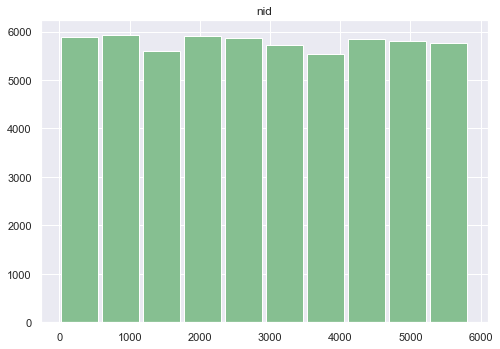

In [26]:
# Histogram
dataset.hist(column='nid', grid=True, figsize=(8,20), layout=(3,1), sharex=True, color='#86bf91', zorder=2, rwidth=0.9)

In [27]:
num_pid = len(dataset.pid.unique())
num_nid = len(dataset.nid.unique())
print('There are {} unique pid and {} unique nid in this dataset '.format(num_pid, num_nid))

There are 5812 unique pid and 5682 unique nid in this dataset 


In [28]:
pid_max = dataset.pid.max()
nid_max = dataset.nid.max()
print('There are {} distinct posts in posts-ctr and the max of pid is {}'.format(num_pid, pid_max))
print('There are {} distinct posts in posts-ctr and the max of nid is {}'.format(num_nid, nid_max))

There are 5812 distinct posts in posts-ctr and the max of pid is 5841
There are 5682 distinct posts in posts-ctr and the max of nid is 5841


#### Creating Model

##### Define Input Layers

In [82]:
def define_input_layers():
    # single level categorical features
    pid_input = Input((1,), name='input_pid')
    nid_input = Input((1,), name='input_nid')
    cat_sl_inputs = [pid_input, nid_input]
    
    # multi level categorical features (with tag_max_len tags at most)
    tag_input = Input((tag_max_len,), name='input_tag')
    cat_ml_inputs = [tag_input]
    
    inputs = cat_sl_inputs + cat_ml_inputs
    return inputs

In [83]:
def Tensor_Mean_Pooling(name='mean_pooling', keepdims=False):
    return Lambda(lambda x: K.mean(x, axis=1, keepdims=keepdims), name=name)

def fm_1d(inputs, n_pid, n_nid, n_tag):
    pid_input, nid_input, tag_input = inputs
    
    # all tensors are reshape to (None, 1)
    cat_sl_embed_1d = [Embedding(n_pid + 1, 1, name='cat_embed_1d_pid')(pid_input), Embedding(n_nid + 1, 1, name='cat_embed_1d_nid')(nid_input)]
    cat_ml_embed_1d = [Embedding(n_tag + 1, 1, mask_zero=True, name='cat_embed_1d_term')(tag_input)]
    
    cat_sl_embed_1d = [Reshape((1,))(i) for i in cat_sl_embed_1d]
    cat_ml_embed_1d = [Tensor_Mean_Pooling(name = 'embed_1d_mean')(i) for i in cat_ml_embed_1d]
    
    # add all tensors
    y_fm_1d = Add(name='fm_1d_output')(cat_sl_embed_1d + cat_ml_embed_1d)
    
    return y_fm_1d

In [84]:
def fm_2d(inputs, n_pid, n_nid, n_tag, k):
    pid_input, nid_input, tag_input = inputs
    
    cat_sl_embed_2d = [Embedding(n_pid + 1, k, name='cat_embed_2d_pid')(pid_input),
                       Embedding(n_nid + 1, k, name='cat_embed_2d_nid')(nid_input)] # shape (None, 1, k)
    
    cat_ml_embed_2d = [Embedding(n_tag + 1, k, name = 'cat_embed_2d_tag')(tag_input)] # shape (None, 3, k)
    cat_ml_embed_2d = [Tensor_Mean_Pooling(name = 'cat_embed_2d_tag_mean', keepdims=True)(i) for i in cat_ml_embed_2d] # shape (None, 1, k)
    
    # concatenate all 2d embed layers => (None, 4, k)
    embed_2d = Concatenate(axis=1, name='concat_embed_2d')(cat_sl_embed_2d + cat_ml_embed_2d)
    
    # calcuate the interactions by simplication: sum of (x1*x2) = sum of (0.5*[(xi)^2 - (xi^2)])
    tensor_sum = Lambda(lambda x: K.sum(x, axis=1), name='sum_of_tensors')
    tensor_square = Lambda(lambda x: K.square(x), name='square_of_tensors')
    
    sum_of_embed = tensor_sum(embed_2d)
    square_of_embed = tensor_square(embed_2d)
    
    square_of_sum = Multiply()([sum_of_embed, sum_of_embed])
    sum_of_square = tensor_sum(square_of_embed)
    
    sub = Subtract()([square_of_sum, sum_of_square])
    sub = Lambda(lambda x: x*0.5)(sub)
    y_fm_2d = Reshape((1,), name='fm_2d_output')(tensor_sum(sub))
    
    return y_fm_2d, embed_2d

In [85]:
def deep_part(embed_2d, dnn_dim, dnn_dr):
    # flat embed layers from 3D to 2D tensors
    y_dnn = Flatten(name = 'flat_embed_2d')(embed_2d)
    for h in dnn_dim:
        y_dnn = Dropout(dnn_dr)(y_dnn)
        y_dnn = Dense(h, activation='relu')(y_dnn)
    y_dnn = Dense(1, activation='relu', name = 'deep_output')(y_dnn)
    
    return y_dnn

In [86]:
def deep_fm_model(n_pid, n_nid, n_tag, k, dnn_dim, dnn_dr):
    inputs = define_input_layers()
    
    y_fm_1d = fm_1d(inputs, n_pid, n_nid, n_tag)
    y_fm_2d, embed_2d = fm_2d(inputs, n_pid, n_nid, n_tag, k)
    y_dnn = deep_part(embed_2d, dnn_dim, dnn_dr)
    
    # combinded deep and fm parts
    y = Concatenate()([y_fm_1d, y_fm_2d, y_dnn])
    y = Dense(1, name='deepfm_output')(y)
    
    fm_model_1d = Model(inputs, y_fm_1d)
    fm_model_2d = Model(inputs, y_fm_2d)
    deep_model = Model(inputs, y_dnn)
    deep_fm_model = Model(inputs, y)
    
    return fm_model_1d, fm_model_2d, deep_model, deep_fm_model

In [87]:
params = {
    'n_pid': pid_max,
    'n_nid': nid_max,
    'n_tag': n_tag,
    'k': 20,
    'dnn_dim':[64,64],
    'dnn_dr': 0.5
}
fm_model_1d, fm_model_2d, deep_model, deep_fm_model = deep_fm_model(**params)

In [88]:
from sklearn.preprocessing import StandardScaler

def df2xy(data):
    x = [data.pid.values,
         data.nid.values,
         np.concatenate(data.related_tags.values).reshape(-1, tag_max_len)]
    
    scaler = StandardScaler()
    standardized = scaler.fit_transform(data.page_view.values.reshape(-1, 1))
    y = standardized.flatten()
    return x,y

# def df2xy(data):
#     x = [data.pid.values,
#          data.nid.values,
#          np.concatenate(data.related_tags.values).reshape(-1, tag_max_len)]
#     y = data.ctr.values
#     return x,y

train_data, valid_data = train_test_split(dataset, test_size=0.5, shuffle=True, random_state=99)
train_x, train_y = df2xy(train_data)
valid_x, valid_y = df2xy(valid_data)

In [89]:
training = True
if not training and os.path.exists('model/deepfm_weights-ctr.h5'):
    deep_fm_model = deep_fm_model.load_weights('model/deepfm_weights-ctr.h5')
else:
    # train  model
    with tf.device('/device:CPU:0'):
        deep_fm_model.compile(loss='MSE', optimizer=tf.keras.optimizers.Adam(0.001))
        early_stop = EarlyStopping(monitor='val_loss', patience=30)
        model_ckp = ModelCheckpoint(filepath='model/deepfm_weights-ctr.h5', monitor='val_loss', save_weights_only=True, save_best_only=True)
        callbacks = [model_ckp, early_stop]
        train_history = deep_fm_model.fit(train_x, train_y, epochs=10000, batch_size=4096, validation_split=0.1, callbacks=callbacks)

Train on 26059 samples, validate on 2896 samples
Epoch 1/10000
26059/26059 [==============================] - 1s 38us/sample - loss: 1.0035 - val_loss: 0.9777
Epoch 2/10000
26059/26059 [==============================] - 0s 3us/sample - loss: 0.9989 - val_loss: 0.9783
Epoch 3/10000
26059/26059 [==============================] - 0s 4us/sample - loss: 0.9950 - val_loss: 0.9788
Epoch 4/10000
26059/26059 [==============================] - 0s 4us/sample - loss: 0.9905 - val_loss: 0.9793
Epoch 5/10000
26059/26059 [==============================] - 0s 4us/sample - loss: 0.9849 - val_loss: 0.9804
Epoch 6/10000
26059/26059 [==============================] - 0s 4us/sample - loss: 0.9787 - val_loss: 0.9821
Epoch 7/10000
26059/26059 [==============================] - 0s 3us/sample - loss: 0.9702 - val_loss: 0.9850
Epoch 8/10000
26059/26059 [==============================] - 0s 4us/sample - loss: 0.9567 - val_loss: 0.9906
Epoch 9/10000
26059/26059 [==============================] - 0s 4us/sample - l

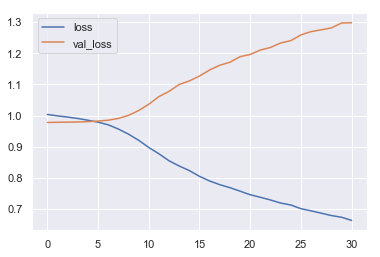

In [90]:
pd.DataFrame(train_history.history).plot()

In [91]:
weights = deep_fm_model.get_weights()
fm_1_weight, fm_2d_weigth, deep_weight = weights[-2]
print("""
contribution of different part of model
    weight of 1st order fm: %5.3f
    weight of 2nd order fm: %5.3f
    weight of dnn part: %5.3f
""" % (fm_1_weight, fm_2d_weigth, deep_weight))


contribution of different part of model
    weight of 1st order fm: -0.661
    weight of 2nd order fm: 1.417
    weight of dnn part: -0.931



##### Model Evaluation

In [92]:
with tf.device('/device:CPU:0'):
    deep_fm_model.evaluate(valid_x, valid_y)

28956/28956 [==============================] - 1s 24us/sample - loss: 1.3482


#### Recommendations

In [97]:
posts.sample(20)

,post_id,title,tags
1716,1162790,"Varises pada Ibu Hamil, Ini Penyebab dan Cara ...","[2, 322, 0, 0, 0]"
574,1640199,"Vagina Robek Saat Persalinan, Ini yang Perlu A...","[13, 149, 0, 0, 0]"
2520,1627588,Mengenal Vertigo Sentral dan Cara Mengobatinya,"[240, 319, 0, 0, 0]"
4402,84687,Berbagai Manfaat Kayu Manis untuk Kesehatan da...,"[36, 5, 10, 1, 14]"
93,1789436,Cegah Influenza di Musim Hujan dengan Vitamin C,"[54, 1, 76, 0, 0]"
2567,1537893,Mengenal Penyebab Biduran dan Cara Mengatasinya,"[24, 367, 0, 0, 0]"
1632,637817,Memahami Fakta tentang Operasi Selaput Dara da...,"[22, 35, 0, 0, 0]"
5631,1229182,Berbagai Penyebab Palpitasi dan Cara Mengatasinya,"[218, 607, 14, 0, 0]"
406,765926,Redakan Ambeien Saat Hamil dengan Cara Sederha...,"[2, 88, 0, 0, 0]"
177,54570,Fistula Ani Penyebab Nyeri Buang Air Besar,"[429, 34, 337, 172, 0]"


##### See on rating data

In [98]:
post_id = 84687
dataset[dataset['post_id'] == post_id]

,post_id,pid,title,related_post_id,nid,related_title,related_tags,page_view
2810,84687,3727,Berbagai Manfaat Kayu Manis untuk Kesehatan da...,87267,1880,Berbagai Nutrisi di Balik Manfaat Bawang Bombay,"[10, 1, 25, 0, 0]",5
2811,84687,3727,Berbagai Manfaat Kayu Manis untuk Kesehatan da...,1715153,3266,Mari Kenali Beberapa Jenis dan Manfaat Polifenol,"[1, 25, 0, 0, 0]",5
2812,84687,3727,Berbagai Manfaat Kayu Manis untuk Kesehatan da...,84687,3727,Berbagai Manfaat Kayu Manis untuk Kesehatan da...,"[36, 5, 10, 1, 14]",4
2813,84687,3727,Berbagai Manfaat Kayu Manis untuk Kesehatan da...,724752,2788,8 Buah untuk Penyakit Jantung yang Patut Dicoba,"[1, 14, 68, 0, 0]",4
2814,84687,3727,Berbagai Manfaat Kayu Manis untuk Kesehatan da...,1612060,4139,Berbagai Manfaat Teh Herbal untuk Kesehatan,"[10, 1, 0, 0, 0]",3
2815,84687,3727,Berbagai Manfaat Kayu Manis untuk Kesehatan da...,64607,1542,Nikmati Manfaat Jus Tomat untuk Kesehatan,"[5, 144, 39, 1, 46]",3
2816,84687,3727,Berbagai Manfaat Kayu Manis untuk Kesehatan da...,82877,4848,Manfaat Keju yang Sayang untuk Dilewatkan,"[5, 15, 154, 1, 0]",2
2817,84687,3727,Berbagai Manfaat Kayu Manis untuk Kesehatan da...,1194279,805,Fakta tentang Manfaat Pare untuk Ibu Hamil,"[10, 2, 1, 0, 0]",2
2818,84687,3727,Berbagai Manfaat Kayu Manis untuk Kesehatan da...,1671983,4564,"Minyak Nabati untuk Kesehatan, Baik atau Buruk?","[226, 1, 0, 0, 0]",1
2819,84687,3727,Berbagai Manfaat Kayu Manis untuk Kesehatan da...,146033,5046,"Kontras dengan Rasa Pahitnya, Manfaat Pare Ter...","[36, 10, 0, 0, 0]",1


##### Find Similarity based on Document to Vector

In [99]:
pid = post_id_pid[post_id]
sims = doc2vec_model.docvecs.most_similar([doc2vec_model[pid]], topn=20)
nids = [nid for nid,_ in sims]
most_similars = dataset[dataset['nid'].isin(nids)].drop_duplicates(subset='nid', keep='last')
most_similars[['related_post_id','nid','related_title','page_view']]

,related_post_id,nid,related_title,page_view
25844,1406429,4902,Simak Manfaat Lada yang Sayang untuk Dilewatkan,3
36300,558775,5259,Jus Strawberry dan Manfaatnya untuk Kesehatan,5
43258,70934,5135,Manfaat Minyak Kelapa Bagi Kesehatan dan Kecan...,1
44474,157676,4343,Berhati-hati Mengambil Manfaat Jamur Ganoderma,3
46938,486213,1286,Ketahui Beragam Manfaat Ketumbar untuk Kesehatan,1
50425,451762,3014,"Sebelum Dikonsumsi, Cek Dulu Risiko-risiko Min...",3
52153,1746078,1399,Kenali Manfaat Guar Gum dan Risiko Efek Sampin...,4
52291,425757,466,"Stevia, Si Manis Rendah Kalori Pengganti Gula",5
52558,87267,1880,Berbagai Nutrisi di Balik Manfaat Bawang Bombay,1
53208,751336,4547,Ini Manfaat Petai Bagi Kesehatan Tubuh Anda,1


##### Scoring based on CTR Collaborative Filtering

In [100]:
# Creating dataset for making recommendations
nids = most_similars.nid.values
pred = [np.array([pid for i in range(len(nids))]),
        nids,
        np.array([dataset[dataset.nid == nid].related_tags.values[0] for nid in nids])]
predictions = deep_fm_model.predict(pred)
predictions = np.array([a[0] for a in predictions])
recommended_ids = (-predictions).argsort()[:20]

recommendations = pd.DataFrame()
nids = [nids[idx] for idx in recommended_ids]
for nid in nids:
    recommendations = recommendations.append(dataset[dataset['nid'] == nid])
recommendations[['related_post_id','nid','related_title','page_view']].drop_duplicates(subset='nid', keep='last')

,related_post_id,nid,related_title,page_view
52291,425757,466,"Stevia, Si Manis Rendah Kalori Pengganti Gula",5
25844,1406429,4902,Simak Manfaat Lada yang Sayang untuk Dilewatkan,3
54514,14629,5657,Berbagai Manfaat Sambiloto untuk Kesehatan,3
44474,157676,4343,Berhati-hati Mengambil Manfaat Jamur Ganoderma,3
36300,558775,5259,Jus Strawberry dan Manfaatnya untuk Kesehatan,5
53891,1669434,4865,Beragam Manfaat Daun Kenikir untuk Kesehatan,5
53208,751336,4547,Ini Manfaat Petai Bagi Kesehatan Tubuh Anda,1
55888,531815,2722,Obat Diet Herbal Bikin Langsing? Ini Faktanya,1
46938,486213,1286,Ketahui Beragam Manfaat Ketumbar untuk Kesehatan,1
58227,84687,3727,Berbagai Manfaat Kayu Manis untuk Kesehatan da...,2
